# MA333 大数据导论 课程项目报告

## 背景

美国的犯罪率一向居高不下，不同行政区域的行政手段对犯罪率有很明显的影响，不同犯罪类型出现的时间也有较大不同。在本次Project中，我们希望通过一些数据分析方法得到犯罪事件与地区、时间的关系，从而达到了解DC地区不同街区犯罪情况，划分地域危险程度的目的。生命财产安全，是人们选择居住区的一个重要指标，我们也希望通过对犯罪情况和不同类型房产价格的分析得出房屋价格与地区犯罪情况的关系。


## 预处理

读入数据，将原始数据存入CRIMES和RPOPERTIES。

In [2]:
# 读入
import lets_plot
import pandas as pd
import numpy as np


PROPERTIES = pd.read_csv('data/DC_Properties.csv').reset_index()
PROPERTIES.drop(PROPERTIES[['Unnamed: 0']], axis=1, inplace=True)
PROPERTIES.set_index('index')

CRIMES = pd.read_csv('data/DC_Crime.csv').reset_index()
CRIMES.set_index('index')

/home/wycer/miniconda3/envs/bigdata/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (18,19,20,21,22,23,24,33,34,35,37,43,45) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,NEIGHBORHOOD_CLUSTER,CENSUS_TRACT,offensegroup,LONGITUDE,END_DATE,offense-text,SHIFT,YBLOCK,DISTRICT,WARD,...,BLOCK,START_DATE,CCN,OFFENSE,OCTO_RECORD_ID,ANC,REPORT_DAT,METHOD,location,LATITUDE
index,,,,,,,,,,,,,,,,,,,,,
0,cluster 21,8702.0,property,-77.003574,2017-04-29T08:00:23.000,theft f/auto,day,138139.0,5.0,5.0,...,150 - 299 block of q street ne,2017-04-29T01:30:14.000,17070672,theft f/auto,17070672-01,5E,2017-04-29T13:49:31.000Z,others,"38.911121322949178,-77.003576581965632",38.911114
1,cluster 16,1600.0,property,-77.026557,2017-04-29T08:30:37.000,theft f/auto,day,146051.0,4.0,4.0,...,7600 - 7699 block of georgia avenue nw,2017-04-29T02:30:10.000,17070675,theft f/auto,17070675-01,4A,2017-04-29T14:38:59.000Z,others,"38.982391883146363,-77.026559339798794",38.982384
2,cluster 8,4702.0,property,-77.020913,2017-04-29T11:10:57.000,theft/other,day,137185.0,1.0,6.0,...,600 - 699 block of k street nw,2017-04-29T10:43:33.000,17070714,theft/other,17070714-01,6E,2017-04-29T15:19:02.000Z,others,"38.902525540064957,-77.020915170313728",38.902518
3,cluster 31,7808.0,property,-76.919601,2017-04-28T09:30:33.000,theft/other,day,135903.0,6.0,7.0,...,5715 5739 block of blaine street ne,2017-04-28T09:15:27.000,17070736,theft/other,17070736-01,7C,2017-04-29T16:11:44.000Z,others,"38.890951021927407,-76.919603310082607",38.890943
4,cluster 39,10900.0,property,-77.003927,2017-04-29T13:42:11.000,theft/other,day,128340.0,7.0,8.0,...,4610 - 4659 block of south capitol street,2017-04-29T13:03:40.000,17070780,theft/other,17070780-01,8D,2017-04-29T18:17:15.000Z,others,"38.822847890448664,-77.003929146312586",38.822840
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
449198,cluster 22,11100.0,property,-76.977167,2021-03-17T20:20:07.000,theft/other,evening,139268.0,5.0,5.0,...,1815 - 1999 block of bryant street ne,2021-03-17T20:15:08.000,21034375,theft/other,21034375-01,5C,2021-03-17T21:07:30.000,others,"38.9212817635688,-76.9771673661107",38.921282
449199,cluster 6,5201.0,property,-77.035546,2021-03-17T17:20:33.000,motor vehicle theft,evening,137976.0,2.0,2.0,...,1500 - 1599 block of p street nw,2021-03-16T21:00:41.000,21034386,motor vehicle theft,21034386-01,2B,2021-03-17T21:38:51.000,others,"38.9096398205834,-77.0355462229667",38.909640
449200,cluster 23,8802.0,property,-76.982015,2021-03-17T23:09:20.000,theft/other,midnight,137150.0,5.0,5.0,...,900 - 999 block of bladensburg road ne,2021-03-17T22:21:45.000,21034407,theft/other,21034407-01,5D,2021-03-18T01:12:46.000,others,"38.9022029472732,-76.9820154636605",38.902203


## 数据可视化以及寻找数据关系

### 查看犯罪数量随时间变化的情况

In [3]:
# 删去重复的数据
crimes = CRIMES.drop_duplicates(inplace=False)

from lets_plot import *

LetsPlot.setup_html()

p = ggplot(crimes, aes(x='YEAR')) + ggsize(500, 250)
p + geom_histogram(binwidth=.5)
p + geom_histogram(
    aes(y='..density..'), binwidth=.5, colour="black", fill="white")


图中可以看出，犯罪数量并没有随时间有明显的比例变化，这是可以按年划分犯罪状况的重要前提。

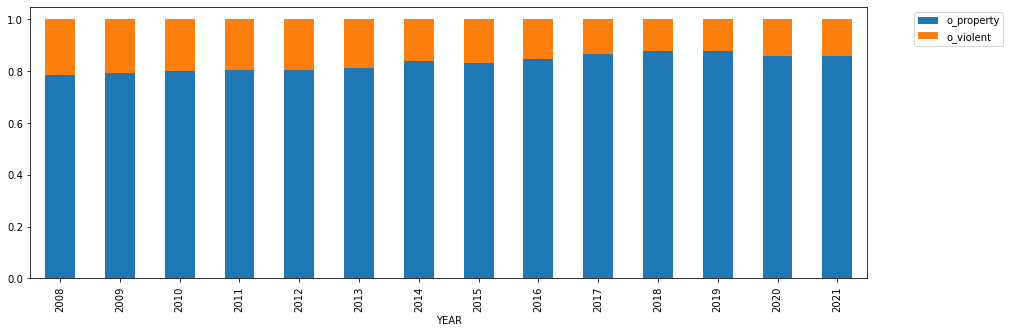

In [34]:
### 查看犯罪类型随时间年份的情况
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["figure.figsize"] = [15, 5]

# 构建数据
crimes = CRIMES.drop_duplicates(inplace=False)
crimes = crimes[crimes['YEAR'].notna()]
crimes.set_index('YEAR')
crimes = crimes[['YEAR', 'offensegroup']]
crimes = pd.get_dummies(crimes, columns=["offensegroup"], prefix="o")

data_set = crimes.groupby('YEAR').sum()
data_set = data_set.div(data_set.sum(axis=1), axis=0)
data_set.head(10)

data_set.plot(kind='bar', stacked = True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


图中可以看出，暴力犯罪在所有犯罪中占的比例在逐年减少。

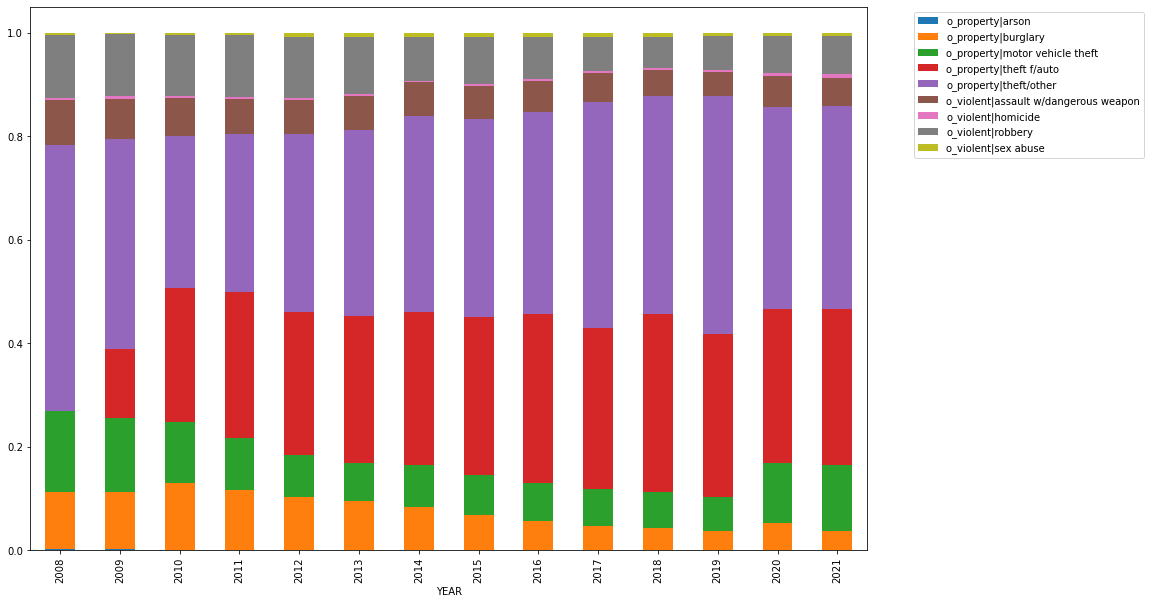

In [35]:
### 查看犯罪详细类型随年份变化的情况
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["figure.figsize"] = [15, 10]

# 构建数据
crimes = CRIMES.drop_duplicates(inplace=False)
crimes = crimes[crimes['YEAR'].notna()]
crimes.set_index('YEAR')
crimes = crimes[['YEAR', 'offensekey']]
crimes = pd.get_dummies(crimes, columns=["offensekey"], prefix="o")

data_set = crimes.groupby('YEAR').sum()
data_set = data_set.div(data_set.sum(axis=1), axis=0)
data_set.head(10)

data_set.plot(kind='bar', stacked = True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


图中可以看出，偷窃占总犯罪的比例在逐年增大。这说明，治安的总体情况有变好的趋势。

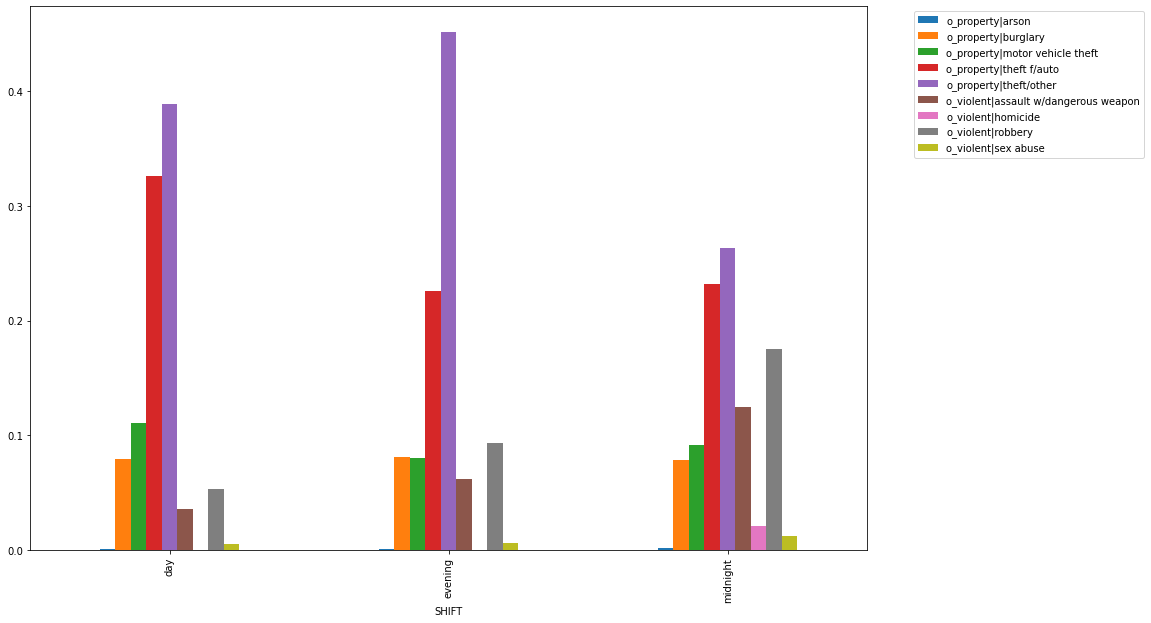

In [5]:
### 查看犯罪详细类型随时间变化的情况
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["figure.figsize"] = [15, 10]

# 构建数据
crimes = CRIMES.drop_duplicates(inplace=False)
crimes = crimes[crimes['SHIFT'].notna()]
crimes.set_index('SHIFT')
crimes = crimes[['SHIFT', 'offensekey']]
crimes = pd.get_dummies(crimes, columns=["offensekey"], prefix="o")

data_set = crimes.groupby('SHIFT').sum()
data_set = data_set.div(data_set.sum(axis=1), axis=0)
data_set.head(10)

data_set.plot(kind='bar', stacked = False)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


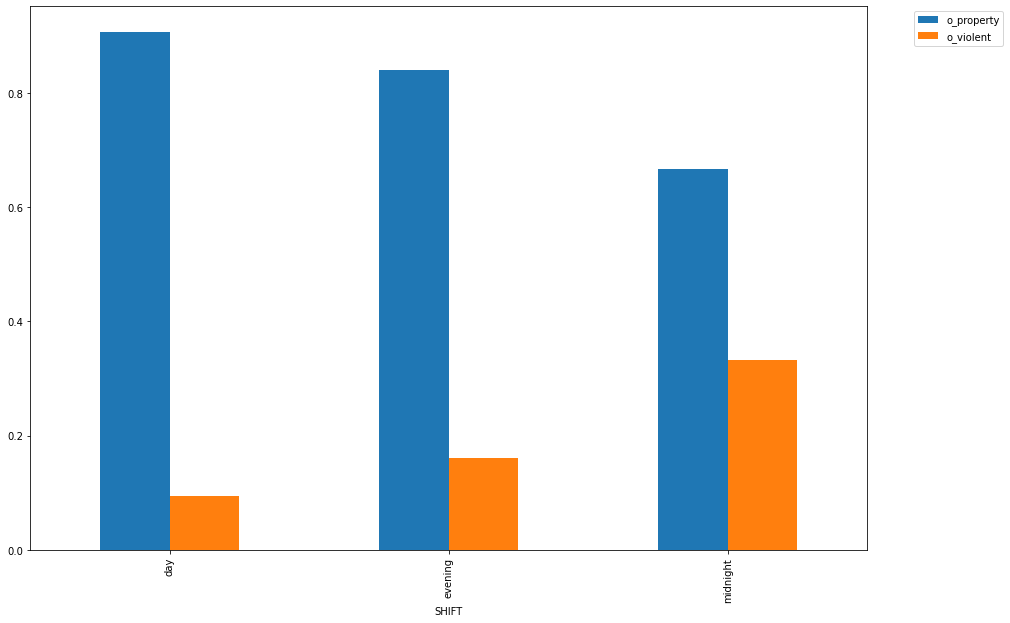

In [6]:
### 查看犯罪详细类型随时间变化的情况
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["figure.figsize"] = [15, 10]

# 构建数据
crimes = CRIMES.drop_duplicates(inplace=False)
crimes = crimes[crimes['SHIFT'].notna()]
crimes.set_index('SHIFT')
crimes = crimes[['SHIFT', 'offensegroup']]
crimes = pd.get_dummies(crimes, columns=["offensegroup"], prefix="o")

data_set = crimes.groupby('SHIFT').sum()
data_set = data_set.div(data_set.sum(axis=1), axis=0)
data_set.head(10)

data_set.plot(kind='bar', stacked = False)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


图中可以看出，谋杀、暴力袭击、性犯罪和抢劫发生在夜晚的比例更高；偷窃更容易发生在白天或者晚上而不是深夜。整体来看，在某一天中的时间越晚越可能出现暴力犯罪。

## 数据相关性分析

### 不同类型犯罪的出现与时间、犯罪方式的相关性

In [9]:
# 犯罪类型/方法/时间
from lets_plot import *
from lets_plot.bistro.corr import *

LetsPlot.setup_html()

df = crimes[["offensegroup", "SHIFT", "offensekey", "METHOD"]]

mpg_df = pd.get_dummies(df, columns=["offensegroup", "SHIFT", "offensekey", "METHOD"])
corr_plot(mpg_df).tiles().labels().build() + ggtitle("Tiles and labels")

从图中可以发现：

1. 谋杀类型的犯罪与午夜时间有弱正相关，与其余时间均为负相关。
2. 抢劫类型的犯罪与午夜有正相关，与白天有负相关。
3. 性犯罪则与时间并无明显的相关关系。
4. 犯罪物品中与枪支和刀相关的犯罪，与暴力犯罪（抢劫、谋杀）有强正相关关系。
5. 犯罪物品中与枪支相关的犯罪，与犯罪类型是抢劫或谋杀呈强正相关关系。

### 犯罪事件与地理位置的相关性

<ipython-input-28-da30da33841e>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['count_by_cluster'] = 1
<ipython-input-28-da30da33841e>:37: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  merged.apply(lambda x: ax.annotate(s=f"{x['neighbourhood']}:{x['count_by_cluster']}", xy=x.geometry.centroid.coords[0], ha='center'),axis=1)


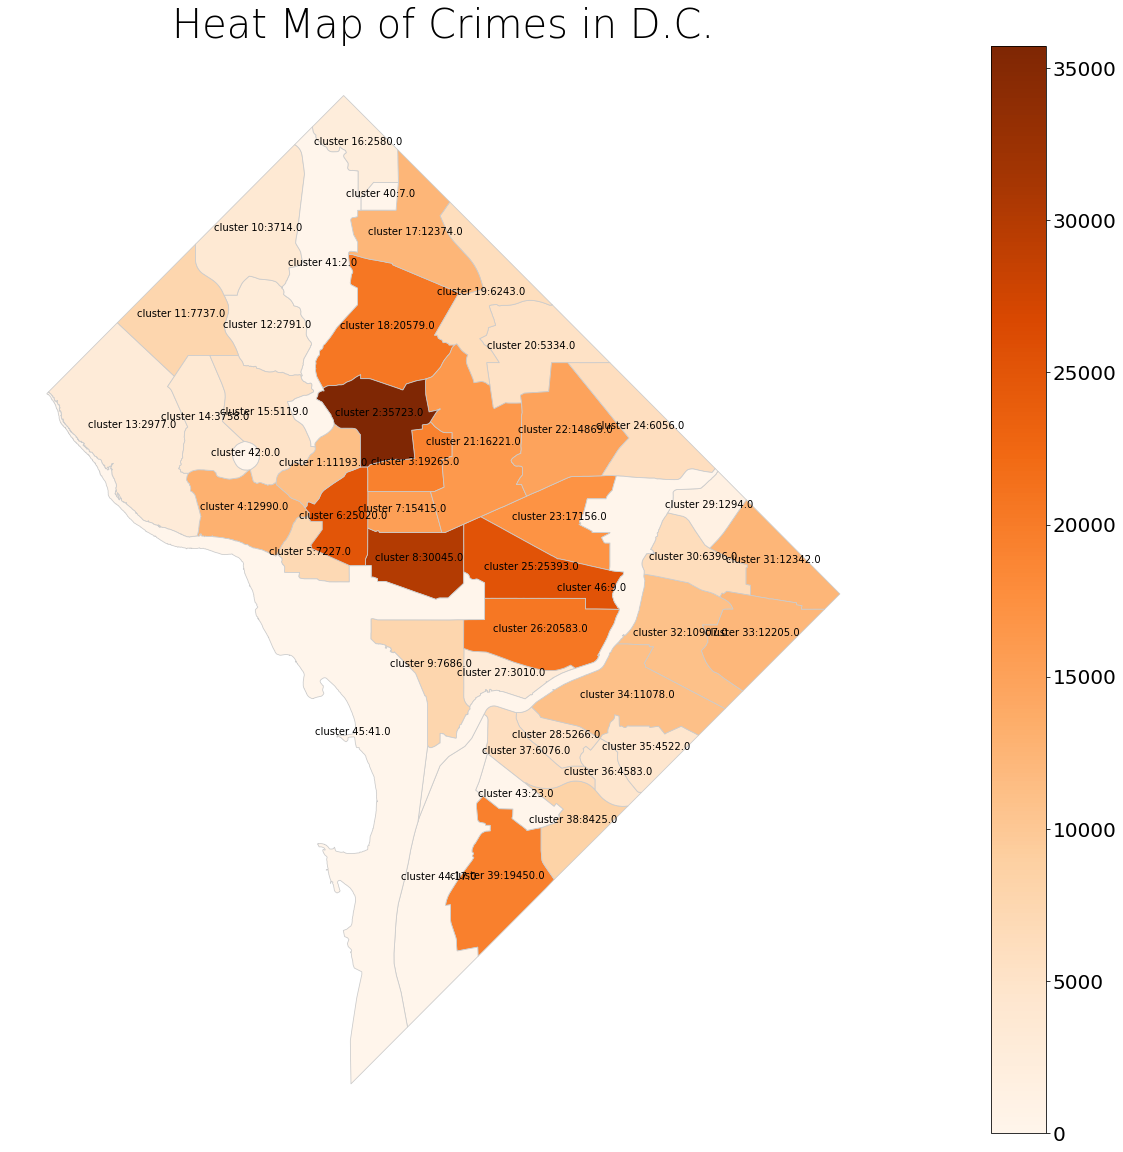

In [28]:
import geopandas as gpd
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
import pandas as pd

dc_map = gpd.read_file('data/Neighborhood_Clusters.shp')
dc_map['neighbourhood'] = dc_map['NAME'].str.lower()

# dc_map.sample(5)
crimes = CRIMES.drop_duplicates(inplace=False)
data = crimes[crimes['NEIGHBORHOOD_CLUSTER'].notna()]
data['count_by_cluster'] = 1
dataByNeighbourhood = data.groupby('NEIGHBORHOOD_CLUSTER').count()[['count_by_cluster']].reset_index()
dataByNeighbourhood['NEIGHBORHOOD_CLUSTER'] = dataByNeighbourhood['NEIGHBORHOOD_CLUSTER'].str.lower()
dataByNeighbourhood.sort_values('count_by_cluster', ascending=False).head(10)


merged = dc_map.set_index('neighbourhood').join(dataByNeighbourhood.set_index('NEIGHBORHOOD_CLUSTER'))
merged = merged.reset_index()
mrged = merged.fillna(0)
# print("Merged: ===============\n", merged)
# merged[['neighbourhood', 'FIELD_11', 'FIELD_12', 'geometry', 'count']].sample(5)

fig, ax = plt.subplots(1, figsize=(40, 20))
ax.axis('off')
ax.set_title('Heat Map of Crimes in D.C.', fontdict={'fontsize': '40', 'fontweight' : '3'})

color = 'Oranges'
vmin, vmax = 0, max(merged['count_by_cluster'])
sm = plt.cm.ScalarMappable(cmap=color, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm)
cbar.ax.tick_params(labelsize=20)

ax = merged.plot('count_by_cluster', cmap=color, linewidth=0.8, ax=ax, edgecolor='0.8', figsize=(40,20))

merged.apply(lambda x: ax.annotate(s=f"{x['neighbourhood']}:{x['count_by_cluster']}", xy=x.geometry.centroid.coords[0], ha='center'),axis=1)

plt.show()

In [ ]:
不同行政区的历年总犯罪数量有巨大差异，由图上可以看出，颜色越深的行政区其出现的犯罪数量越多。

/home/wycer/miniconda3/envs/bigdata/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
<ipython-input-3-acff30c65d07>:136: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  merged.apply(lambda x: ax.annotate(s=f"{x['neighbourhood']}:{int(x['type'])}", xy=x.geometry.centroid.coords[0], ha='center'),axis=1)


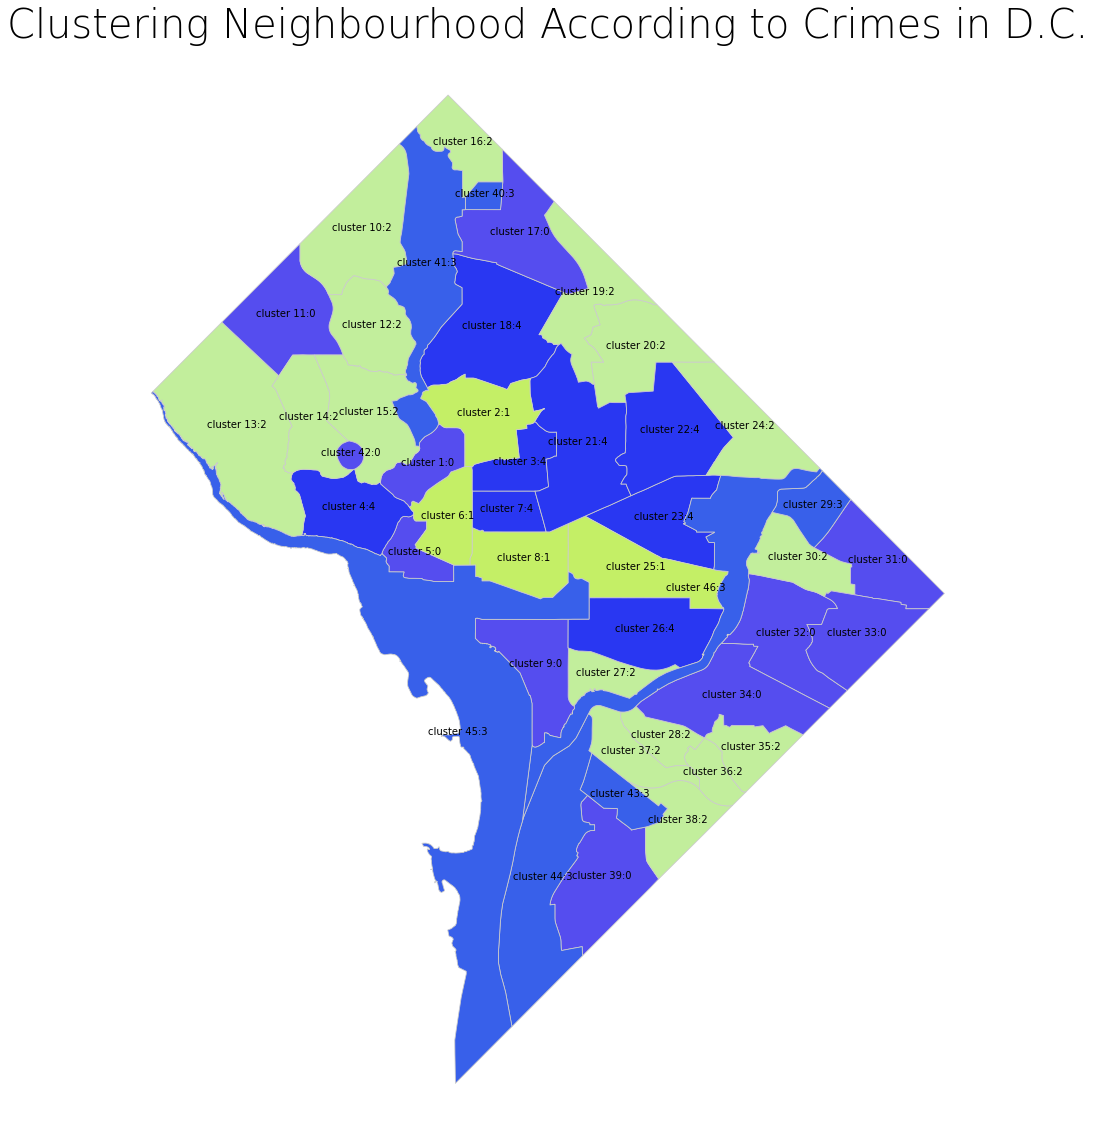

In [3]:
def rand_cmap(nlabels, type='bright', first_color_black=True, last_color_black=False, verbose=True):
    """
    Creates a random colormap to be used together with matplotlib. Useful for segmentation tasks
    :param nlabels: Number of labels (size of colormap)
    :param type: 'bright' for strong colors, 'soft' for pastel colors
    :param first_color_black: Option to use first color as black, True or False
    :param last_color_black: Option to use last color as black, True or False
    :param verbose: Prints the number of labels and shows the colormap. True or False
    :return: colormap for matplotlib
    """
    from matplotlib.colors import LinearSegmentedColormap
    import colorsys
    import numpy as np


    if type not in ('bright', 'soft'):
        print ('Please choose "bright" or "soft" for type')
        return

    if verbose:
        print('Number of labels: ' + str(nlabels))

    # Generate color map for bright colors, based on hsv
    if type == 'bright':
        randHSVcolors = [(np.random.uniform(low=0.0, high=1),
                          np.random.uniform(low=0.2, high=1),
                          np.random.uniform(low=0.9, high=1)) for i in range(nlabels)]

        # Convert HSV list to RGB
        randRGBcolors = []
        for HSVcolor in randHSVcolors:
            randRGBcolors.append(colorsys.hsv_to_rgb(HSVcolor[0], HSVcolor[1], HSVcolor[2]))

        if first_color_black:
            randRGBcolors[0] = [0, 0, 0]

        if last_color_black:
            randRGBcolors[-1] = [0, 0, 0]

        random_colormap = LinearSegmentedColormap.from_list('new_map', randRGBcolors, N=nlabels)

    # Generate soft pastel colors, by limiting the RGB spectrum
    if type == 'soft':
        low = 0.6
        high = 0.95
        randRGBcolors = [(np.random.uniform(low=low, high=high),
                          np.random.uniform(low=low, high=high),
                          np.random.uniform(low=low, high=high)) for i in range(nlabels)]

        if first_color_black:
            randRGBcolors[0] = [0, 0, 0]

        if last_color_black:
            randRGBcolors[-1] = [0, 0, 0]
        random_colormap = LinearSegmentedColormap.from_list('new_map', randRGBcolors, N=nlabels)

    # Display colorbar
    if verbose:
        from matplotlib import colors, colorbar
        from matplotlib import pyplot as plt
        fig, ax = plt.subplots(1, 1, figsize=(15, 0.5))

        bounds = np.linspace(0, nlabels, nlabels + 1)
        norm = colors.BoundaryNorm(bounds, nlabels)

        cb = colorbar.ColorbarBase(ax, cmap=random_colormap, norm=norm, spacing='proportional', ticks=None,
                                   boundaries=bounds, format='%1i', orientation=u'horizontal')

    return random_colormap
# 做一个地域的分类（使用地域的犯罪情况）
# Test GEO
import geopandas as gpd
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
import pandas as pd

dc_map = gpd.read_file('data/Neighborhood_Clusters.shp')
dc_map['neighbourhood'] = dc_map['NAME'].str.lower()

# dc_map.sample(5)

crimes = CRIMES.drop_duplicates(inplace=False)
data = crimes[crimes['NEIGHBORHOOD_CLUSTER'].notna()]
data = data[['NEIGHBORHOOD_CLUSTER', 'offensekey']]
data = pd.get_dummies(data, columns=["offensekey"])

data = data.groupby('NEIGHBORHOOD_CLUSTER').sum().reset_index()
data_set = data.drop(columns=['NEIGHBORHOOD_CLUSTER'], inplace=False)
data_set.head(10)

# dataByNeighbourhood = data.groupby('NEIGHBORHOOD_CLUSTER').count()[['count_by_cluster']].reset_index()
# dataByNeighbourhood['NEIGHBORHOOD_CLUSTER'] = dataByNeighbourhood['NEIGHBORHOOD_CLUSTER'].str.lower()
# data_set.sort_values('NEIGHBORHOOD_CLUSTER', ascending=False).head(100)

# data_set = data[['NEIGHBORHOOD_CLUSTER']]
# snapshot(data_set)
# # print()

import pandas as pd
from sklearn import cluster
model = cluster.KMeans(n_clusters=5, max_iter=100, n_jobs=4, init="k-means++")
model.fit(data_set)

r = pd.concat([data, pd.Series(model.labels_, index=data.index)], axis=1)
r.columns = list(data.columns) + ['type']

r.head(10)

# ['NEIGHBORHOOD_CLUSTER', 'CENSUS_TRACT', 'offensegroup', 'LONGITUDE',
#        'END_DATE', 'offense-text', 'SHIFT', 'YBLOCK', 'DISTRICT', 'WARD',
#        'YEAR', 'offensekey', 'BID', 'sector', 'PSA', 'ucr-rank', 'BLOCK_GROUP',
#        'VOTING_PRECINCT', 'XBLOCK', 'BLOCK', 'START_DATE', 'CCN', 'OFFENSE',
#        'OCTO_RECORD_ID', 'ANC', 'REPORT_DAT', 'METHOD', 'location', 'LATITUDE',
#        'count_by_cluster'],

merged = dc_map.set_index('neighbourhood').join(r.set_index('NEIGHBORHOOD_CLUSTER'))
merged = merged.reset_index()
merged = merged.fillna(0)
# print("Merged: ===============\n", merged)
# merged[['neighbourhood', 'FIELD_11', 'FIELD_12', 'geometry', 'count']].sample(5)

fig, ax = plt.subplots(1, figsize=(40, 20))
ax.axis('off')
ax.set_title('Clustering Neighbourhood According to Crimes in D.C.', fontdict={'fontsize': '40', 'fontweight' : '3'})

vmin, vmax = 0, max(merged['type'])
# cmap = matplotlib.colors.ListedColormap ( numpy.random.rand ( 256,3))
vals = np.linspace(0,1,256)
np.random.shuffle(vals)
sm = rand_cmap(100, type='bright', first_color_black=False, last_color_black=False, verbose=False)
# cbar = fig.colorbar(sm)
# cbar.ax.tick_params(labelsize=20)

ax = merged.plot('type', cmap=sm, linewidth=0.8, ax=ax, edgecolor='0.8', figsize=(40,20))

merged.apply(lambda x: ax.annotate(s=f"{x['neighbourhood']}:{int(x['type'])}", xy=x.geometry.centroid.coords[0], ha='center'),axis=1)
plt.show()

In [ ]:
按照犯罪数量与类型对行政区进行多变量聚类，我们把同类行政区染色比较，结果与先前的犯罪数量与行政区的关系是接近一致的。

In [ ]:
import geopandas as gpd
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
import pandas as pd
dc_map = gpd.read_file('data/Neighborhood_Clusters.shp')
dc_map['neighbourhood'] = dc_map['NAME'].str.lower()


properties = PROPERTIES.drop(columns=['CITY', 'STATE', 'X', 'Y', 'SOURCE'])
properties = properties.dropna(axis=0, how='any', subset=['PRICE'])
properties = properties.drop(properties[properties['QUALIFIED'] == 'U'].index)
properties = properties.drop(columns=['QUALIFIED'])
properties.set_index('index')

# properties = properties[:25]
print(len(properties))

properties['neighbourhood'] = ""

cnt = 0

def find(x):
    global cnt
    p = Point(x["LONGITUDE"], x["LATITUDE"])

    return dc_map[dc_map['geometry'].contains(p)]['neighbourhood'].iloc[0]
        
properties['neighbourhood'] = properties.apply(lambda x: find(x) ,axis=1)

properties.head(25)

In [76]:
properties.to_csv("data/properties.csv")

In [188]:

crimes = CRIMES.drop_duplicates(inplace=False)
crimes = crimes[crimes['NEIGHBORHOOD_CLUSTER'].notna()]
crimes = crimes[['NEIGHBORHOOD_CLUSTER', 'offensegroup', 'REPORT_DAT']]
crimes = pd.get_dummies(crimes, columns=["offensegroup"])
crimes['DATE'] = pd.to_datetime(crimes['REPORT_DAT'], utc=True)
crimes['YEAR'] = crimes['DATE'].dt.year
crimes = crimes.groupby(['NEIGHBORHOOD_CLUSTER', 'YEAR']).sum()

crimes.head()

offensegroup_property  offensegroup_violent
NEIGHBORHOOD_CLUSTER YEAR                                             
cluster 1            2008                  776.0                 189.0
                     2009                  701.0                 163.0
                     2010                  723.0                 142.0
                     2011                  852.0                 167.0
                     2012                  804.0                 160.0

对于犯罪数据，先将其按照报告的日期("REPORT_DAT")提取出案件发生的年份（"YEAR"），按犯罪发生的年份以及犯罪发生的行政区进行划分，再对其内部不同的犯罪类型进行求和。得到不同的行政区不同年份发生各类犯罪的数量。

In [111]:
properties['SALE_DATE'] = pd.to_datetime(properties['SALEDATE'], utc=True)
properties['YEAR'] = properties['SALE_DATE'].dt.year

properties.head()

,index,BATHRM,HF_BATHRM,HEAT,AC,NUM_UNITS,ROOMS,BEDRM,AYB,YR_RMDL,...,ASSESSMENT_NBHD,ASSESSMENT_SUBNBHD,CENSUS_TRACT,CENSUS_BLOCK,WARD,SQUARE,QUADRANT,neighbourhood,SALE_DATE,YEAR
0,0,4,0,Warm Cool,Y,2.0,8,4,1910.0,1988.0,...,Old City 2,040 D Old City 2,4201.0,004201 2006,Ward 2,152,NW,cluster 6,2003-11-25 00:00:00+00:00,2003
2,2,3,1,Hot Water Rad,Y,2.0,9,5,1910.0,2009.0,...,Old City 2,040 D Old City 2,4201.0,004201 2006,Ward 2,152,NW,cluster 6,2016-06-21 00:00:00+00:00,2016
3,3,3,1,Hot Water Rad,Y,2.0,8,5,1900.0,2003.0,...,Old City 2,040 D Old City 2,4201.0,004201 2006,Ward 2,152,NW,cluster 6,2006-07-12 00:00:00+00:00,2006
5,5,3,2,Hot Water Rad,Y,1.0,10,5,1913.0,NaN,...,Old City 2,040 D Old City 2,4201.0,004201 2006,Ward 2,152,NW,cluster 6,2010-02-26 00:00:00+00:00,2010
7,7,3,1,Hot Water Rad,Y,2.0,8,4,1906.0,2011.0,...,Old City 2,040 D Old City 2,4201.0,004201 2005,Ward 2,152,NW,cluster 6,2011-09-29 00:00:00+00:00,2011


对于房产数据，先按其销售的日期提取出房屋销售的年份。

将犯罪数据和房产数据通过行政区和年份进行合并，可以得到房屋出售的时候的房屋属性以及同年同行政区的犯罪情况。

在新的数据集中，犯罪情况可能为NaN，因为可能出现某些房屋出售同年同行政区没有发生过犯罪，我们将这些缺失值填充为0。

在新的数据集中，删去一些不会显著影响房屋价格的参数，比如销售日期，邮编，街区号，经纬度等等。

在新的数据集中，对于房屋等级和条件的评定，将其按好坏线性映射为一个整数值，越高表示属性越好。

将新的数据集中除了价格外的特征作为X训练集，将新的数据集中的价格作为Y训练集，进行回归的训练。




In [198]:
data_set = pd.merge(properties, crimes,  how='left', left_on=['neighbourhood','YEAR'], right_on = ['NEIGHBORHOOD_CLUSTER','YEAR'])

data_set[['offensegroup_property', 'offensegroup_violent']] = data_set[['offensegroup_property', 'offensegroup_violent']].fillna(value=0)

data_set = data_set.drop(columns=['SALE_DATE', 'YEAR', 'QUADRANT', 'neighbourhood', 'CENSUS_TRACT', 'CENSUS_BLOCK', 'ZIPCODE', 'USECODE', 'CMPLX_NUM', 'ASSESSMENT_NBHD', 'ASSESSMENT_SUBNBHD', 'NATIONALGRID', 'FULLADDRESS', 'GIS_LAST_MOD_DTTM', 'WARD'])

data_set = data_set.drop(columns=['LATITUDE', 'LONGITUDE'])

data_set = data_set.drop(columns=['INTWALL', 'EXTWALL', 'STYLE', 'STORIES', 'SALEDATE', 'ROOF', 'STRUCT', 'BLDG_NUM'])

data_set = data_set.drop(columns=['LIVING_GBA', 'SQUARE'])

data_set = data_set.drop(columns=['HEAT'])

data_set['GRADE'] = data_set['GRADE'].map({
    "Average": 1,
    "Above Average": 2,
    "Good Quality": 3,
    "Very Good": 4,
    "Excellent": 5,
    "Superior": 6,
    "Exceptional-A": 7,
    "Exceptional-B": 8,
    "Exceptional-C": 9,
    "Exceptional-D": 10,
    "Fair Quality": 0,
    "Low Quality": -1
})

data_set['CNDTN'] = data_set['CNDTN'].map({
    "Good": 2,
    "Average": 3,
    "Very Good": 4,   
    "Excellent": 5,  
    "Fair": 1, 
    "Poor": 0       
})
data_set['AC'] = data_set['AC'].map({
    "Y": 1,
    "N": 0      
})

data_set = data_set.dropna()

train_x = data_set.drop(columns=['PRICE'])
train_y = data_set[['PRICE']]


/home/wycer/miniconda3/envs/bigdata/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
[ 425831.01724367  869393.01693655 1167170.87442494  297021.52664847
  294355.15116158  725002.96804351  509750.79573746  500527.22804395
  296193.47726165  227935.27438795  212817.75743329  190226.27980905
  203636.00911259  314339.45170315  342924.03861714  289131.9073548
   96286.36262182  112021.84642343  205535.61877857  292864.00953202
  144245.27446595   62910.2329753    78866.39036176   78866.39036176
  171405.10693694  162066.62945238  341634.24041114   80667.67869272
  281616.20687475  315207.64793333  113559.73954101  120346.44864068
  125188.70167859  346008.04877391  353132.93852057  228600.33857026
  284077.16851076  319784.33899666  351131.56008719  192135.7197303
  221257.64987541  271019.552753

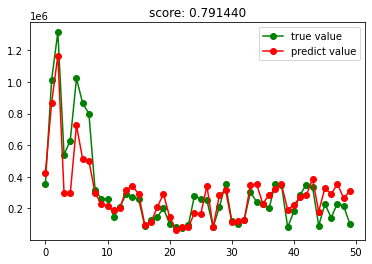

In [223]:

x_train, y_train = train_x[:-50], train_y[:-50] #数据前两列是x1,x2 第三列是y,这里的y有随机噪声
x_test ,y_test = train_x[-50:], train_y[-50:] # 同上,不过这里的y没有噪声

###########2.回归部分##########
def try_different_method(model):
    model.fit(x_train,y_train)
    score = model.score(x_test, y_test)
    result = model.predict(x_test)
    print(result)
    plt.figure()
    plt.plot(np.arange(len(result)), y_test,'go-',label='true value')
    plt.plot(np.arange(len(result)),result,'ro-',label='predict value')
    plt.title('score: %f'%score)
    plt.legend()
    plt.show()


from sklearn import ensemble
model_GradientBoostingRegressor = ensemble.GradientBoostingRegressor(n_estimators=100)
try_different_method(model_GradientBoostingRegressor)

对于房屋价格，我们使用了多种方法尝试进行回归，其中GBRT的表现最好。GBRT的 $R^2$ 是0.791440。

## 总结

对于DC地区犯罪情况的数据，我们首先做了简单的数据分析。我们发现每年DC地区出现的总犯罪数量是较为一致的，不存在某一年非常多或某一年非常少，这是按年划分犯罪状况的重要前提。随后的相关性分析说明暴力犯罪更容易出现在深夜，而经济犯罪更容易出现在白天，且枪支刀具的使用与暴力犯罪正相关。暴力犯罪的数量和比例在逐年小幅度减少，犯罪的数量和类型与行政区也有明显的联系。对于房屋价格，我们使用多种方法进行回归，然后保留结果最优秀的方法GBRT，以GBRT的结果作为我们对不同地区不同状况房屋价格的预测。